In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# by: Rafael_Scherer, MD, PhD
# date: 0203/23
# version ='1.0'

# Libs

In [1]:
from IPython.display import display, HTML
import cv2
import numpy as np
from matplotlib import image
from matplotlib import pyplot as plt
import json
from sklearn import preprocessing

#Show Matplotlib's plots inside a Jupyter Notebook
%matplotlib inline

# Dataset

In [3]:
display(HTML("""<a href="https://github.com/uw-biomedical-ml/uwhvf">
(UWHVF) University of Washington - Humphrey Visual Fields </a>"""))
print('Description: Dataset of 26,353 HVFs 24-2 (Goldmann stimulus size III - SITA, SITA Fast, Full-threshold)\nfrom 3895 patients and 7463 eyes.\nData-structure consists of nested dictionaries in JSON file format.')

Description: Dataset of 26,353 HVFs 24-2 (Goldmann stimulus size III - SITA, SITA Fast, Full-threshold)
from 3895 patients and 7463 eyes.
Data-structure consists of nested dictionaries in JSON file format.


# Load data

In [4]:
with open("E:/Felipe_Medeiros_CVC/uwhvf/alldata.json") as fin:
  dat = json.loads(fin.read())

# Basic statistics
print(f"Total of {dat['pts']} patients, {dat['eyes']} eyes, and {dat['hvfs']} HVFs")

Total of 3871 patients, 7428 eyes, and 28943 HVFs


# Example data

In [5]:
print('Right HVF:')
print(np.array(dat['data']['647']['R'][0]['hvf']))
print(75*'#')
print('Right TD:')
print(np.array(dat['data']['647']['R'][0]['td']))

Right HVF:
[[100.   100.   100.    26.34  23.73  22.84  24.19 100.   100.  ]
 [100.   100.    26.25  27.22  25.67  26.18  27.01  26.24 100.  ]
 [100.    22.2   28.17  29.2   28.44  27.58  28.51  28.02  25.68]
 [ 20.4   27.41  29.73  30.02  30.93  30.36  30.64  21.    27.89]
 [ 20.45  25.88  28.9   32.17  31.89  30.91  28.8    0.    27.43]
 [100.    27.16  29.98  32.74  29.95  32.07  29.84  26.99  27.3 ]
 [100.   100.    26.88  29.43  29.82  28.64  29.81  28.24 100.  ]
 [100.   100.   100.    28.88  27.3   26.82  28.18 100.   100.  ]]
###########################################################################
Right TD:
[[100.   100.   100.    -3.23  -5.88  -6.43  -4.72 100.   100.  ]
 [100.   100.    -4.77  -4.51  -6.26  -5.42  -4.09  -4.29 100.  ]
 [100.    -8.91  -4.39  -4.18  -5.29  -5.85  -4.3   -3.97  -5.51]
 [ -9.04  -4.48  -3.82  -4.45  -3.83  -4.12  -3.21  21.    -4.07]
 [ -9.04  -6.13  -4.78  -2.51  -3.16  -3.94  -5.34   0.    -4.91]
 [100.    -4.35  -3.12  -1.36  -4.67  -2.36 

# Organize data

In [6]:
patients = dat['data']
ids = patients.keys()


lst = []  # VF's list [patient's Id, age, right hvf, right td, left hvf, left td]

for p in ids:  # Patient's Loop
    try:
        rfield = patients[p]['R']
        
        for c, r in enumerate(rfield):  # VF's Loop
            
            try:  # Only bilateral VF
                l = patients[p]['L'][c]
                lst.append([p, r['age'], r['hvf'], r['td'], l['hvf'], l['td']])
            except AttributeError as ae:
                pass
            except IndexError as ie:
                pass
    except KeyError as ke:  # No Right Side
        pass
    
print(f'Total VF after filtering: {len(lst)}')

Total VF after filtering: 13622


# Normalize the data attributes

In [7]:
def second_largest(list):
    list = np.unique(list)
    list.sort()
    return list[-2]


def normal(l: list) -> list:
    flatten = list(np.concatenate(l).flat)  # Turn 1D

    
    amin, amax = min(flatten), second_largest(flatten)  #HVF: 0-50
    
    if amin < 0:
        new = []
        [new.append(x - amin)  if x != 100 else new.append(x) for x in flatten]
        amax = amax - amin
        amin = 0
        flatten = new
    
    f = []
    [f.append(x) if x != 100 else f.append(0) for x in flatten]  # Strip 100
    
    exp = []
    for i, val in enumerate(f):
        if val == 0 and amin == 0 and amax == 0:
            exp.append(0)
        else:
            value = int(round((val - amin)**2 / (amax - amin)**2 *255, 0))
            if val == 0:
                exp.append(0)
            else:  
                exp.append(value)  # Normalize 0-255 exponentially
    exp = np.reshape(np.array(exp), (-1, 9))
    return exp
    

def toimg(age, hvf, td) -> list:
    age = int(round(age/100 * 255, 0 ))
    
    img = []
    for l in range(0, 8):
        line = []
        for c in range(0, 18):
            line.append([ hvf[l][c], td[l][c], age])  # [R, G, B] Colors
        img.append(line)

    return img


images = []
for i, vf in enumerate(lst):
    try:
        hvf = np.concatenate((normal(vf[2]), np.flip(normal(vf[4]))), axis=1)
        td = np.concatenate((normal(vf[3]), np.flip(normal(vf[5]))), axis=1)
    except ValueError as ve:
        print(i)

    if i == 20:  # Print example
        print('HVF:')
        print(hvf)
        print(75*'#')
        print('TD:')
        print(td)
    img = toimg(vf[1], hvf, td)
    images.append(img)


np.save('E:/Felipe_Medeiros_CVC/images_array.npy', images) # save

HVF:
[[  0   0   0  93  69  78  88   0   0   0   0 167 186 168 198   0   0   0]
 [  0   0 167 150 137 163 122  92   0   0 182 185 182 190 193 200   0   0]
 [  0 160  81 155 130 107 135 113 153 200 202 216 216 196 215 214 201   0]
 [ 31  66  86 119 141 203 149   0 142 164  73 229 255 203 183 181 199 156]
 [130 129 214 182 222 255 214  73 158 214  14 100 223   0   0   0   5   0]
 [  0 156 255 236 211 206 198 145 172 197 123   0   0   0   0   0   4   0]
 [  0   0 197 204 217 184 199 159   0   0 154  20   0   0   0   0   0   0]
 [  0   0   0 124 174 189 159   0   0   0   0 122   8   0   0   0   0   0]]
###########################################################################
TD:
[[  0   0   0   7   3   5   8   0   0   0   0  85  93  86 103   0   0   0]
 [  0   0  15  10   7  12   7   4   0   0  89  87  84  87  91 100   0   0]
 [  0  13   0   6   2   1   5   4  12  98  95  97  93  83  94 100 104   0]
 [  0   0   0   1   2   9   4 110   7  82 255 100 107  84  78  82 100  96]
 [ 14   5  13 

# Turn in to image

In [ ]:
def turnimage(img, serial, path):
    fig, ax = plt.subplots(figsize=[10, 10])
    ax.imshow(img)
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.savefig(f'{path}{lst[serial][0]}_{serial}.png')  # Patient ID_Serial


for c, i in enumerate(images): 
    turnimage(i, c, 'E:/Felipe_Medeiros_CVC/images/png/')
        


# Find Clusters

In [8]:
"""
THIRDPARTY (EDITED):

(author: Anson Wong / git: ankonzoid)

"""
import os
import numpy as np
import tensorflow as tf
from sklearn.neighbors import NearestNeighbors
from CV_transform_utils import apply_transformer
from CV_transform_utils import resize_img, normalize_img
from CV_plot_utils import plot_query_retrieval, plot_tsne, plot_reconstructions
from autoencoder import AutoEncoder
import skimage.io


imgs = np.load('E:/Felipe_Medeiros_CVC/images_array.npy')  # All Images
shape_img = imgs[0].shape
print("Image shape = {}".format(shape_img))
parallel = False
modelName = "simpleAE"

# Build models
# Set up autoencoder
info = {
    "shape_img": shape_img,
    "autoencoderFile": 'E:/Felipe_Medeiros_CVC/images/output/simpleAE/simpleAE_autoecoder.h5',
    "encoderFile": 'E:/Felipe_Medeiros_CVC/images/output/simpleAE/simpleAE_encoder.h5',
    "decoderFile": 'E:/Felipe_Medeiros_CVC/images/output/simpleAE/simpleAE_decoder.h5',
}
model = AutoEncoder(modelName, info)
model.set_arch()

shape_img_resize = shape_img
input_shape_model = (model.encoder.input.shape[1],)
output_shape_model = (model.encoder.output.shape[1],)


# Print some model info
print("input_shape_model = {}".format(input_shape_model))
print("output_shape_model = {}".format(output_shape_model))

# Apply transformations to all images
class ImageTransformer(object):

    def __init__(self, shape_resize):
        self.shape_resize = shape_resize

    def __call__(self, img):
        img_transformed = resize_img(img, self.shape_resize)
        img_transformed = normalize_img(img_transformed)
        return img_transformed

transformer = ImageTransformer(shape_img_resize)
print("Applying image transformer to training images...")
imgs_transformed = apply_transformer(imgs, transformer, parallel=parallel)

# Convert images to numpy array
X = np.array(imgs_transformed).reshape((-1,) + input_shape_model)
print(" -> X.shape = {}".format(X.shape))

# Load Model
model.load_models(loss="binary_crossentropy", optimizer="adam")

# Create embeddings using model
print("Inferencing embeddings using pre-trained model...")
E = model.predict(X)
E_flatten = E.reshape((-1, np.prod(output_shape_model)))
print(" -> E.shape = {}".format(E.shape))
print(" -> E_flatten.shape = {}".format(E_flatten.shape))

# Fit kNN model on training images
print("Fitting k-nearest-neighbour model on training images...")
knn = NearestNeighbors(n_neighbors=5, metric="cosine")
knn.fit(E_flatten)

for e in E_flatten:
    _, indices = knn.kneighbors([e]) # find k nearest neighbours
    break



Image shape = (8, 18, 3)

autoencoder.summary():
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 432)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               55424     
_________________________________________________________________
dense_1 (Dense)              (None, 432)               55728     
Total params: 111,152
Trainable params: 111,152
Non-trainable params: 0
_________________________________________________________________
None

encoder.summary():
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 432)]             0         
_________________________________________________________________
dense (Dense)                (

In [ ]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard
import tensorboard
tensorboard.__version__
%tensorboard --logdir logs

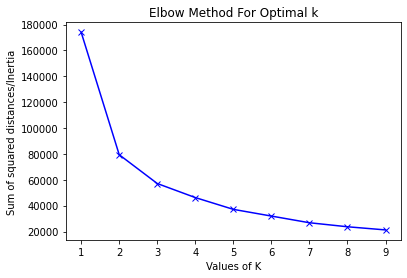

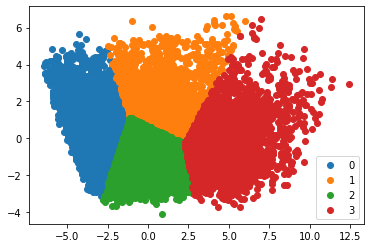

In [127]:
# Clusters
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt



#Transform the data
pca = PCA(2)
df = pca.fit_transform(E_flatten)


Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters, n_init='auto', init = "k-means++", max_iter = 300, random_state = 0)
    kmeans.fit(df)
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()


#Initialize the class object
kmeans = KMeans(n_clusters= 4, n_init='auto', init = "k-means++", max_iter = 300, random_state = 0)
 
#predict the labels of clusters.
label = kmeans.fit_predict(df)

#Getting unique labels
u_labels = np.unique(label)
 
#plotting the results:
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)

plt.legend()
plt.show()

In [128]:
def turnimage(img, serial, path):
    fig, ax = plt.subplots(figsize=[10, 10])
    ax.imshow(img)
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.savefig(f'{path}{lst[serial][0]}_{serial}.png')  # Patient ID_Serial

Centroids 0 -> 1 -> 2 -> 3


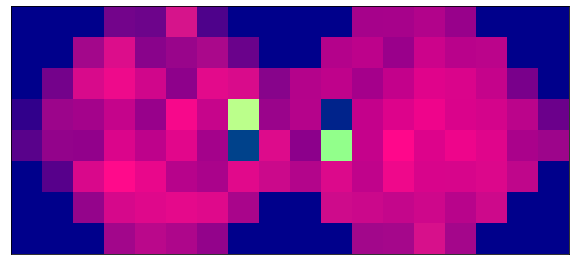

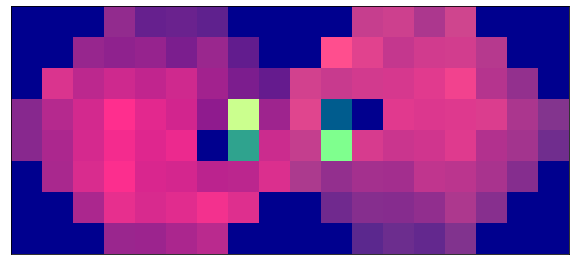

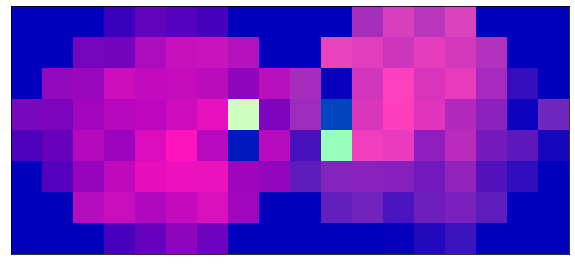

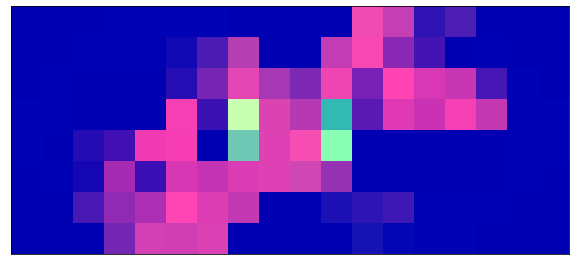

In [131]:
clusters = kmeans.labels_

from sklearn.metrics import pairwise_distances_argmin_min

closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, df)
closest

print('Centroids 0 -> 1 -> 2 -> 3')
for c, i in enumerate(closest):
    turnimage(images[i], c, f'E:/Felipe_Medeiros_CVC/images/centroids/')

Random: Label 0
[6298, 8467, 3322, 509, 6246, 12304, 3801, 8132, 8832, 5570, 7041, 6361, 10160, 7809, 4226, 9735, 2541, 13022, 9764, 4272, 13375, 7317, 11259, 13221, 10718, 3164, 2864, 10998, 6929, 1226, 11284, 794, 10167, 6323, 9647, 3657, 856, 11415, 3073, 4683, 11406, 1371, 7980, 7738, 10663, 11249, 4937, 333, 11707, 9200, 1077, 5102, 3314, 2726, 6784, 5602, 3514, 954, 9200, 11343, 1191, 9413, 8501, 5827, 2444, 11863, 10031, 2932, 7246, 254, 6471, 11985, 10091, 6359, 5580, 5158, 2830, 11823, 5117, 5697, 7363, 9317, 4007, 9572, 154, 5045, 10116, 8312, 5373, 7345, 4652, 10673, 268, 5949, 10208, 5482, 8922, 12043, 4773, 12794]


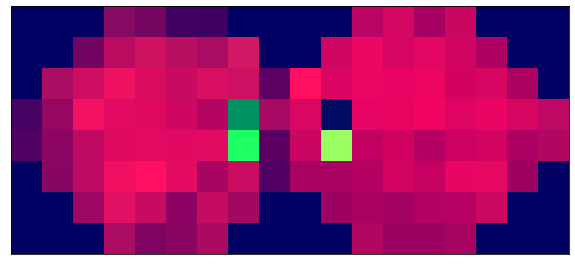

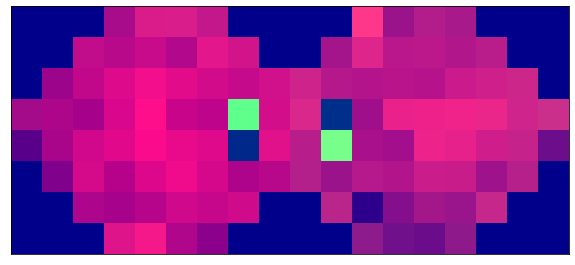

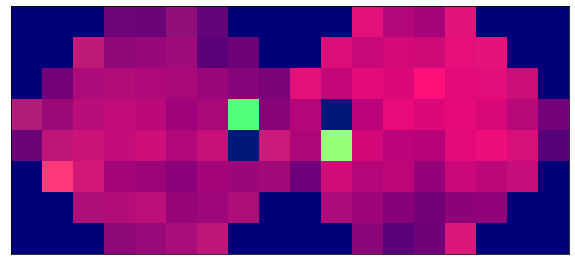

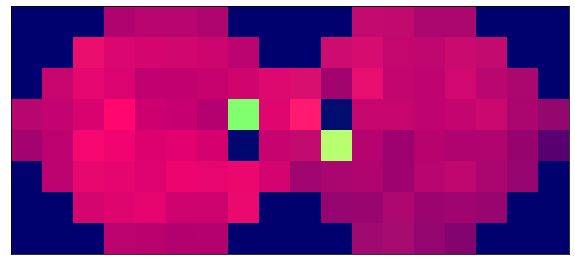

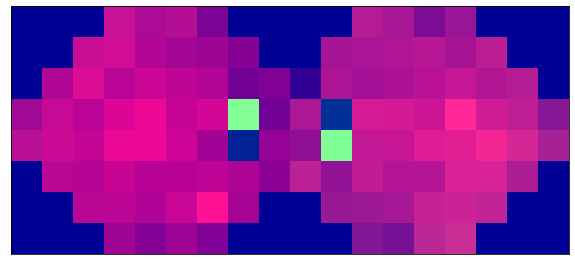

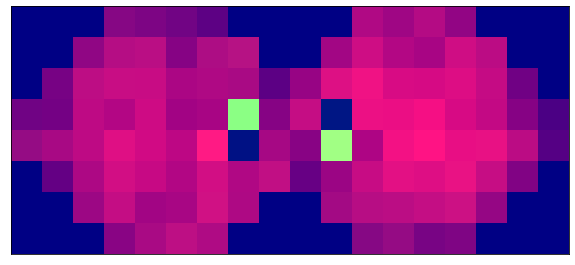

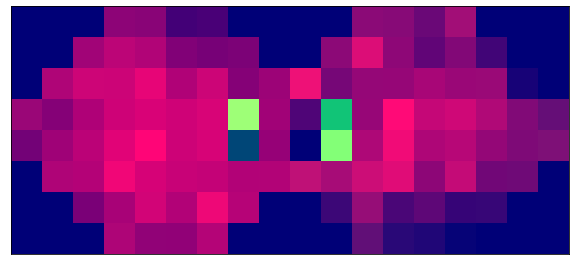

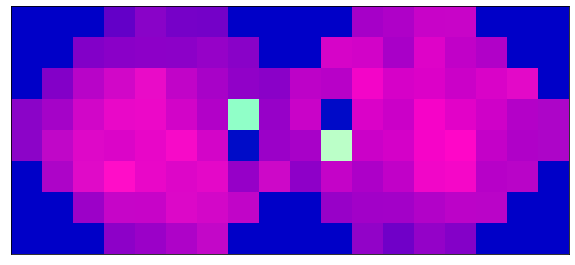

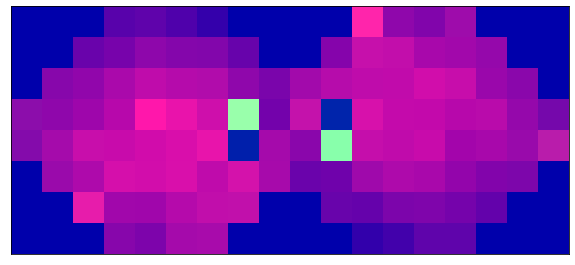

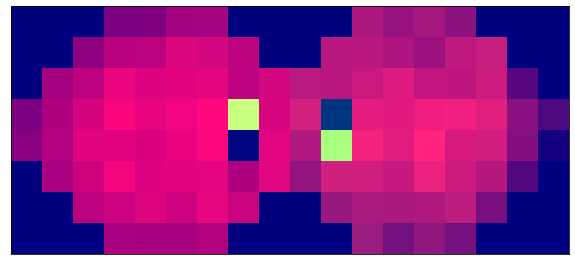

In [134]:
print('Random: Label 0')
import random


random = [random.randint(0, len(lst)) for iter in range(100)]
print(random)
counter = 0
for i in random:
    if clusters[i] == 0:
        turnimage(images[i], i, f'E:/Felipe_Medeiros_CVC/images/random_normal/')
        counter += 1
    if counter == 10:
        break

In [111]:
# Network Graph

from bokeh.io import output_notebook, show, save
import pandas as pd
output_notebook()

from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
import networkx

from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Spectral8
from networkx.algorithms import community



Loading BokehJS ...

In [39]:
from tqdm import tqdm

dist = []
for c, e in tqdm(enumerate(E_flatten)):
    _, indices = knn.kneighbors([e]) # find k nearest neighbours
    indices = indices[0]
    _ = _[0]
    for i in range(1, len(indices)):
        dist.append([c, indices[i], _[i], clusters[c]])  # Origin, Target, Distance

13622it [01:06, 204.09it/s]


In [40]:
df = pd.DataFrame(dist, columns =['Source', 'Target', 'Weight', 'Cluster'])

df.to_csv('E:/Felipe_Medeiros_CVC/NetworkGraph.csv', index=False)

got_df = pd.read_csv('E:/Felipe_Medeiros_CVC/NetworkGraph.csv')

In [122]:
sample = got_df.sample(frac = 0.1)  # Sample from Data to fit the network plot rendering

In [123]:
G = networkx.from_pandas_edgelist(sample, 'Source', 'Target', 'Weight')

In [124]:
clt = df[['Cluster']].to_dict()['Cluster']
networkx.set_node_attributes(G, name='cluster', values=clt)
#Pick a color palette — Blues8, Reds8, Purples8, Oranges8, Viridis8
color_palette = Blues8

In [125]:
#Choose a title!
title = 'Network Graph - Nearest NearestNeighbors'

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [("Image", "@index"), ("Cluster", "@cluster"),]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title)

#Create a network graph object with spring layout
network_graph = from_networkx(G, networkx.spring_layout, scale=10, center=(0, 0))

#Set node size and color
network_graph.node_renderer.glyph = Circle(size=15, fill_color='skyblue')

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

show(plot)

# Prepare for GAN Anomaly Detection

In [152]:
# Cut and Split Dataset

drt = os.listdir('E:/Felipe_Medeiros_CVC/images/GAN/train/OTHER')

normal = []
abnormal = []
for i, c in tqdm(enumerate(clusters)):
    for d in drt:
        if str('_' + str(i) + '.png') in d:
            if c == 0:  # Normal
                normal.append(d)
            else:  # Abnormal
                abnormal.append(d)
            break        

13622it [00:34, 399.14it/s]


In [155]:
from random import sample


test_normal = sample(normal, int(len(normal)*0.2))
test_abnormal = sample(abnormal, int(len(abnormal)*0.2))

In [164]:
# Cut
PATH = 'E:/Felipe_Medeiros_CVC/images/GAN/train/OTHER'
PATH_Train_Normal = 'E:/Felipe_Medeiros_CVC/images/GAN/train/NORMAL'
PATH_Test_Normal = 'E:/Felipe_Medeiros_CVC/images/GAN/test/NORMAL'
PATH_Test_Abnormal = 'E:/Felipe_Medeiros_CVC/images/GAN/test/OTHER'


for i in test_normal:
    try:
        os.rename(f'{PATH}/{i}', f'{PATH_Test_Normal}/{i}')
    except:
        pass
    
for i in test_abnormal:
    try:
        os.rename(f'{PATH}/{i}', f'{PATH_Test_Abnormal}/{i}')
    except:
        pass
for i in normal:
    try:
        os.rename(f'{PATH}/{i}', f'{PATH_Train_Normal}/{i}')
    except:
        pass

In [196]:
# GAN PREDICTIONS

df = pd.read_csv('E:/Felipe_Medeiros_CVC/images/GAN/PREDICTIONS.csv', delimiter=';', )
df

,CLASS,INFER,SCORE,ORIG
0,NORMAL,NORMAL,"0,949828453","0,050171547"
1,NORMAL,NORMAL,"0,947292145","0,052707855"
2,NORMAL,NORMAL,"0,977086492","0,022913508"
3,NORMAL,NORMAL,"0,974890938","0,025109062"
4,NORMAL,NORMAL,"0,974125618","0,025874382"
...,...,...,...,...
2718,ANOMALOUS,ANOMALOUS,"0,141483724","0,141483724"
2719,ANOMALOUS,ANOMALOUS,"0,083821058","0,083821058"
2720,ANOMALOUS,ANOMALOUS,"0,103233032","0,103233032"
2721,ANOMALOUS,ANOMALOUS,"0,104120947","0,104120947"


In [227]:
lt = df.values.tolist()


normal_prob = []
abnormal_prob = []
for l in lt:
    orig = float(l[3].replace(',', '.'))
    
    if l[0] == 'NORMAL':
        normal_prob.append(orig*100)
    else:
        abnormal_prob.append(orig*100)
    

In [243]:
# Gera matriz de confusao
def matriz(l1, l2, c=50):  # Recebe as listas de proba dos dois grupos e calcula a matriz para um ponto de corte
    vp = 0
    fp = 0
    vn = 0
    fn = 0
    lrn = 0
    
    for i in range(0, len(l1)):
        if l1[i] > c:
            vp +=1
        else:
            fn += 1
    
    for i in range(0, len(l2)):
        if l2[i] > c:
            fp +=1
        else:
            vn += 1
    
    try:
        acc = round(((vp + vn) / sum([vp, vn, fp, fn]))*100, 2)
        sen = round(((vp) / sum([vp, fn]))*100, 2)
        esp = round(((vn) / sum([vn, fp]))*100, 2)
        vpp = round(((vp) / sum([vp, fp]))*100, 2)
        vpn = round(((vn) / sum([vn, fn]))*100, 2)  # Youden Index
        yi = round(sen/100 + esp/100 - 1, 2)
        if esp == 100:
            lrp = 0
        else:
            lrp = round(sen / (100 - esp), 2)
        
        if esp == 0:
            lrp = 0
        else:
            lrn = round((100 - sen) / esp, 2)
    except ZeroDivisionError as e:
        acc, sen, esp, vpp, vpn, lrp, lrn, yi = 0, 0, 100, 0, 0, 0, 0, 0
    
    print(f'VP: {vp}, FP: {fp}, VN: {vn}, FN: {fn}')
    return acc, sen, esp, vpp, vpn, lrp, lrn, yi

In [244]:
# Gerar Curva ROC
mat = []
for i in range(0, 50):
    print(f'CORTE: {i}')
    m = matriz(abnormal_prob, normal_prob, c=i)
    print(m)
    print(75*'#')
    mat.append(m)


CORTE: 0
VP: 1827, FP: 896, VN: 0, FN: 0
(0, 0, 100, 0, 0, 0, 0, 0)
###########################################################################
CORTE: 1
VP: 1827, FP: 896, VN: 0, FN: 0
(0, 0, 100, 0, 0, 0, 0, 0)
###########################################################################
CORTE: 2
VP: 1827, FP: 896, VN: 0, FN: 0
(0, 0, 100, 0, 0, 0, 0, 0)
###########################################################################
CORTE: 3
VP: 1810, FP: 788, VN: 108, FN: 17
(70.44, 99.07, 12.05, 69.67, 86.4, 1.13, 0.08, 0.11)
###########################################################################
CORTE: 4
VP: 1751, FP: 637, VN: 259, FN: 76
(73.82, 95.84, 28.91, 73.32, 77.31, 1.35, 0.14, 0.25)
###########################################################################
CORTE: 5
VP: 1652, FP: 437, VN: 459, FN: 175
(77.52, 90.42, 51.23, 79.08, 72.4, 1.85, 0.19, 0.42)
###########################################################################
CORTE: 6
VP: 1490, FP: 161, VN: 735, FN: 337
(8

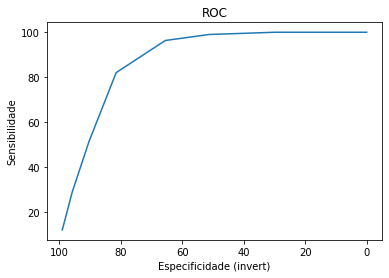

In [245]:
s = []
s2 = []
e = []
e2 = []
for i in mat:
    if i[1] > 0:
        s.append(i[1])
        s2.append(i[1]/100)

        e.append(i[2])
        e2.append((i[2])/100)

plt.plot(s, e)
plt.title("ROC")
plt.ylabel('Sensibilidade')
plt.xlabel('Especificidade (invert)')
plt.gca().invert_xaxis()
plt.show()


In [246]:
best_cutpoint = matriz(abnormal_prob, normal_prob, c=6)  # Select by the best Youden Index
print(f'Accuracy: {best_cutpoint[0]}%, Sensivity: {best_cutpoint[1]}%, Specificity: {best_cutpoint[2]}%')
print(f'True Positive Rate: {best_cutpoint[3]}%, True Negative Rate: {best_cutpoint[4]}5, Likelihood Ratio+ {best_cutpoint[5]}x, Likelihood Ratio- {best_cutpoint[6]}x')

VP: 1490, FP: 161, VN: 735, FN: 337
Accuracy: 81.71%, Sensivity: 81.55%, Specificity: 82.03%
True Positive Rate: 90.25%, True Negative Rate: 68.565, Likelihood Ratio+ 4.54x, Likelihood Ratio- 0.22x
